### 使用fastai v2 重写ssd by fastai course-v2 2018 part2 pascal_multi.ipynb
- fastai V2 重写 https://nbviewer.org/github/jav0927/course-v3/blob/master/SSD_Object_Detection.ipynb

#### Data

In [1]:
" 使用fastai v2 重写ssd by fastai course-v2 2018 part2 pascal_multi.ipynb "

# data pascal_voc2007

import warnings
warnings.filterwarnings('ignore')


from pathlib import Path
from fastai.vision.all import *


path = Path('/home/helen/dataset/pascal_2007')

trn_im_names, trn_truths = get_annotations(path/'train.json')
val_im_names, val_truths = get_annotations(path/'valid.json')
# tst_im_names, tst_truths = get_annotations(path/'test.json') 
tot_im_names, tot_truths = [trn_im_names + val_im_names, trn_truths + val_truths]

img_y_dict = dict(zip(tot_im_names, tot_truths))
truth_data_func = lambda o: img_y_dict[o.name]

sz=224       # Image size
bs=64        # Batch size

item_tfms = [Resize(sz, method='squish'),]
batch_tfms = [Rotate(), Flip(), Dihedral()]

getters = [lambda o: path/'train'/o, lambda o: img_y_dict[o][0], lambda o: img_y_dict[o][1]]

pascal = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                   splitter=RandomSplitter(),
                   getters=getters,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms,
                   n_inp=1)
dls = pascal.dataloaders(tot_im_names,bs=bs)
# dls.vocab

In [2]:
# Deals with both GPU and CPU environments
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

### Anchor & help funcs
- 由于fastai v1和v2都是 [-1,1]，所以anchor也要是[-1,1]
- 也有一种处理是anchor让人[0,1]，但是box先转为[0,1]，可以注意下这里的变化

In [3]:
#convert center/height/width to fastai top left and bottom right coordinates
def cthw2corners(boxes):
    top = (boxes[:,0] - boxes[:,2]/2).view(-1,1)
    left = (boxes[:,1] - boxes[:,3]/2).view(-1,1)
    bot = (boxes[:,0] + boxes[:,2]/2).view(-1,1)
    right = (boxes[:,1] + boxes[:,3]/2).view(-1,1)
    return torch.cat([top,left,bot,right],dim=1)

In [4]:
anc_grids = [4, 2, 1]
anc_zooms = [0.75, 1., 1.3]
anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms 
                                    for (i,j) in anc_ratios]
# *** Number of Anchor Scales
k = len(anchor_scales)
# ***************************

anc_offsets = [2/(o*2) for o in anc_grids] #2 is the h,w in fastai 1.0 (-1,1)
anc_x = np.concatenate([np.repeat(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes = np.concatenate([np.array([[2*o/ag,2*p/ag] 
              for i in range(ag*ag) for o,p in anchor_scales])
                 for ag in anc_grids]) #2/grid * scale,2 is the h,w in fastai 1.0
grid_sizes = tensor(np.concatenate([np.array([ 1/ag 
              for i in range(ag*ag) for o,p in anchor_scales])
                  for ag in anc_grids])).unsqueeze(1) *2 #again fastai 1.0 h,w is 2
anchors = tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float()
anchor_cnr = cthw2corners(anchors)
anchor_cnr = anchor_cnr.to(device)
anchors = anchors.to(device)

# plt.scatter(anc_x, anc_y) # 可视化anchor
# show_anchors(anchors, [4,4])

In [5]:
# Filter out all zero-valued bounding boxes
def un_pad(boxes,labels):
    # bb_keep = ((boxes[:,2] - boxes[:,0])>0) # for TensorBox格式
    boxes = torch.tensor(boxes)
    labels = torch.tensor(labels)
    bb_keep = ((boxes[:,2] - boxes[:,0])>0).nonzero()[:,0] # tensor格式Bbox
    return boxes[bb_keep],labels[bb_keep]

# Calculate the area of a bounding box
def box_area(boxes):
    return (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])

# Calculate the intersection of two given bounding boxes
def intersect(box_a,box_b):
    #make sure box_a and box_b exists, otherwise undefine behavior if you call the func
    top_left = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    bot_right = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp((bot_right - top_left),min=0)
    return inter[:,:,0] * inter[:,:,1]

# Calculate Jaccard (IOU)
def iou(bbox,anchor):
    #bbox is gt_bb, anchor is anchor box, all in fastai style
    if len(bbox.shape) == 1: bbox = bbox[None,...]
    inter = intersect(bbox,anchor)
    union = box_area(bbox).unsqueeze(dim=1) + box_area(anchor).unsqueeze(dim=0) - inter #to broadcast shape to (N,16),where N is number of gt_bb for single image
    return inter / union

# Display generated anchor grid
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid(True, which='both')
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

# Transform activations to bounding box format
def act_to_bbox(activation,anchor):
    activation = torch.tanh(activation) #force scale to be -1,1
    act_center = anchor[:,:2] + (activation[:,:2]/2 * grid_sizes.float().to(activation.device))
    act_hw = anchor[:,2:] * (activation[:,2:]/2 + 1)
    return cthw2corners(torch.cat([act_center,act_hw],dim=1))

  # Map to Ground Truth
def map_to_gt(overlaps):
    prior_overlap,prior_idx = overlaps.max(dim=1)
    sec_overlap,sec_idx = overlaps.max(dim=0)
    sec_overlap[prior_idx] = 4.99
    for i,o in enumerate(prior_idx): 
        sec_idx[o] = i
    return sec_overlap,sec_idx



In [6]:
def is_unfreeze(learner):
    '''
    Determines whether the next-to-last layer in the model is set to unfreeze or freeze
    '''
    c = 0
    for each in list(learner.model.body[-1][0].parameters()):
      if each.requires_grad: c += 1   
    if c == len(list(learner.model.body[-1][0].parameters())):
      return True 
    else:
      return False
    
def find_optimal_lr(learner, noise=5, show_df=None, show_min_values=False):
    '''
    Parameters
    
      learner:  The learner (mandatory)
      
      (Optional)
      noise:   Filtering parameter, set to 5. Suggest no to modify this value
      
      show_df: 'head' - Show the top 50 rows, 
               'tail' - Show the tail 50 rows
    
      show_min_values: True  - Display all values, min, and max 
                       False - Display min_loss and max_grad values
    
    Returns:
      optimun_lr - if freeze = True
      Suggested Best Slice - if freeze = False
      
    Author:  J. Adolfo Villalobos @ 2019  
    '''
    
    # Get loss values, corresponding gradients, and lr values from model.recorder
    loss = np.array(learner.recorder.losses)
    loss_grad = np.gradient(loss)   
    # Transform lrs list to np array
    lrs = np.array(learner.recorder.lrs, dtype='float32')
    
    # Create a DataFrame with the data
    data = {'loss': loss.T, 'loss_grad': loss_grad.T, 'lrs': lrs.T}
    df = pd.DataFrame(data, columns=['loss', 'loss_grad', 'lrs', 'min_loss', 'max_loss', 'min_grad', 'max_grad'])
      
    # Populate "min" and "max" columns for loss and gradient values filtering the noise with argrelextrema.     
    from scipy.signal import argrelextrema
    
    #********
    # IMPORTANT: n filters noise (sharp spikes in the data). Higher n value filters noise more aggressively. 
    # n = 5 seems to work best
    n=noise    
    #********
    
    df.min_loss = df.iloc[argrelextrema(df.loss.values, np.less_equal, order=n)[0]]['loss']
    df.max_loss = df.iloc[argrelextrema(df.loss.values, np.greater_equal, order=n)[0]]['loss']
    df.min_grad = df.iloc[argrelextrema(df.loss_grad.values, np.less_equal, order=n)[0]]['loss_grad']
    df.max_grad = df.iloc[argrelextrema(df.loss_grad.values, np.greater_equal, order=n)[0]]['loss_grad']

    # Optional: Display dataframe if show_df=True
    if show_df == 'head': print(df.head(50)) 
    elif show_df == 'tail': print(df.tail(50))     
        
    # Plot losses and loss gradients against lr values
    plt.figure(figsize=[8, 5])
    #figs, ax = plt.subplots(1,1)
    ax = plt.gca()
    color_loss = 'blue'
    color_grad = 'orange'
    color_green = 'green'
    color_red = 'red'

    ax.xaxis.grid(True)
    ax.set_ylabel('Loss')
    ax.set_title('Learn Rate Finder')
    ax.tick_params(axis='y', labelcolor=color_loss)
    ax.semilogx(df.lrs, df.loss, c=color_loss )
    
    # Define variable vertical size of the plot window, depending on the graph shape
    u_limit = max(df.loss.loc[(df.lrs < 0.1)].max(), 250)*2    
    ax.set_ylim([-200, u_limit])
   
    # Plot resulting line graphs
    ax2 = ax.twinx()
    ax2.set_ylabel('loss', color= color_grad)
    ax2.semilogx(df.lrs, df.loss_grad, c = color_grad)
    ax2.tick_params(axis='y', labelcolor = color_grad)
    
    # plot inflection points
    ax.scatter(df.lrs, df.min_loss, c = color_red)    
    ax2.scatter(df.lrs, df.min_grad, c = color_red)    
    if show_min_values:
      ax.scatter(df.lrs, df.max_loss, c = color_green)
      ax2.scatter(df.lrs, df.max_grad, c = color_green) 
    
    # Legends
    plt.LogFormatter(labelOnlyBase=False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True, shadow=True)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=3, fancybox=True, shadow=True)
    plt.show()
    
    # Display resulting lr values, format varies depending of the state of the model's 
    # next-to-last layer ggroup: set to freeze or unfreeze    
    if is_unfreeze(learn):
      # Yellow min_grad graph
      rev_tru_idx = df.min_grad.notna()[::-1]   
      optimun_lr_upper_bound_g = df.lrs.iloc[rev_tru_idx.idxmax()] 
      rev_tru_idx[rev_tru_idx.idxmax()] = np.NaN      
      optimun_lr_lower_bound_1_g = df.lrs.iloc[rev_tru_idx.idxmax()]
      rev_tru_idx[rev_tru_idx.idxmax()] = np.NaN      
      optimun_lr_lower_bound_2_g = df.lrs.iloc[rev_tru_idx.idxmax()] 
      
      # Blue loss graph
      rev_tru_idx_loss = df.min_loss.notna()[::-1]   
      optimun_lr_upper_bound_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 
      rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = np.NaN      
      optimun_lr_lower_bound_1_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()]
      rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = np.NaN      
      optimun_lr_lower_bound_2_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 
      
      # Print results and return choices of lr slice
      print('Model set to: "unfreeze" or "freeze_to:"')      
      data = {'*Gradient - Orange Graph*' : [optimun_lr_upper_bound_g, optimun_lr_lower_bound_1_g, optimun_lr_lower_bound_2_g], 
              '*Loss - Blue Graph*' : [optimun_lr_upper_bound_l, optimun_lr_lower_bound_1_l, optimun_lr_lower_bound_2_l]}
      prdf = pd.DataFrame(data, index = ['First choice lr:', 'Second choice lr:', 'Third choice lr:' ])
      pd.options.display.float_format = '{:.10E}'.format
      #prdf.style.applymap('color: %s' % color_grad, subset=['*Gradient - Orange Graph*'])
      print(prdf)
       
      return optimun_lr_lower_bound_1_g, optimun_lr_upper_bound_g
      
    else:
        
      optimun_lr_upper_bound = df.lrs.iloc[df.min_grad.notna()[::-1].idxmax()]
      optimun_lr_lower_bound = df.lrs.iloc[df.min_loss.notna()[::-1].idxmax()]/10
      # Print results and return optimal lr
      print('Model set to "freeze":')
      print('  Optimun lr: {:.10E} '.format(optimun_lr_upper_bound))
      print('  Min loss divided by 10: {:.10E}'.format(optimun_lr_lower_bound))
      return optimun_lr_upper_bound 

### Model

In [7]:
# Method used to match the shape of the conv_ssd_layer to the ground truth's shape
def flatten_conv(x,k):
    # Flatten the 4x4 grid to dim16 vectors
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)
    

# Standard convolution with stride=2 to halve the size of the image
class conv2_std_layer(nn.Module):
    def __init__(self, ni, nf, stride=2, drop=0.1):
        super().__init__()
        self.cnv = nn.Conv2d(ni, nf, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nf)
        self.drp = nn.Dropout(drop)
        
    def forward(self, x):
        return self.drp(self.bn(F.relu(self.cnv(x))))

# SSD convolution that camptures bounding box and class
class conv2_ssd_layer(nn.Module):
    def __init__(self, ni, k, no_cls, bias=-3.):
        super().__init__()
        self.k = k 
        self.oconv1 = nn.Conv2d(ni, no_cls*self.k, 3, padding=1)
        self.oconv2 = nn.Conv2d(ni, 4*self.k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        return [flatten_conv(self.oconv2(x), self.k), # 先box，再label
                flatten_conv(self.oconv1(x), self.k)]

class ssd_model(nn.Module):
    def __init__(self, arch=models.resnet34, k=9 , drop=0.4, no_cls=21, bias=-3.):
        super().__init__()
        self.k = k
        self.body = create_body(arch(True))
        self.drop = nn.Dropout(0.2)   # it was 0.25

        self.std_conv_0 = conv2_std_layer(512, 256, drop=drop,stride=1)
        # Dimension-reducing  layers
        self.std_conv_1 = conv2_std_layer(256, 256, drop=drop, stride=2) # 4 by 4 layer
        self.std_conv_2 = conv2_std_layer(256, 256, drop=drop, stride=2) # 2 by 2 layer
        self.std_conv_3 = conv2_std_layer(256, 256, drop=drop, stride=2) # 1 by 1 layer
        # Standard layers
        self.ssd_conv_1 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls, bias=bias)
        self.ssd_conv_2 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls, bias=bias)
        self.ssd_conv_3 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls, bias=bias)
        
    def forward(self, xb):
        xb = self.drop(F.relu(self.body(xb)))
        xb = self.std_conv_0(xb)
        xb = self.std_conv_1(xb)
        bb1, cls1 = self.ssd_conv_1(xb) # 4 x 4
        xb = self.std_conv_2(xb)
        bb2, cls2 = self.ssd_conv_2(xb) # 2 x 2
        xb = self.std_conv_3(xb)     
        bb3, cls3  = self.ssd_conv_3(xb) # 1 x 1
        
        return [torch.cat([bb1, bb2, bb3], dim=1), 
                torch.cat([cls1, cls2, cls3], dim=1)]

In [8]:
 
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels].cuda()

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    def get_weight(self,x,t): return None
    def forward(self, pred, targ):
        t = one_hot_embedding(targ.squeeze(), self.num_classes)
        t = t[:,1:] # Start from 1 to exclude the Background
        x = pred[:,1:]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w.detach(), reduction='sum')/self.num_classes
  
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)
    
# loss function
loss_f = FocalLoss(len(dls.vocab))

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = un_pad(bbox,clas)
    a_ic = act_to_bbox(b_bb, anchors) # 之前的代码是有问题的，应该先转换激活元
    overlaps = iou(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_gt(overlaps) # 找到真实的anchor
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[~pos] = 0
    gt_bbox = bbox[gt_idx]
    # loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    loc_loss = ((TensorBase(a_ic[TensorBase(pos_idx)]) - TensorBase(gt_bbox[TensorBase(pos_idx)])).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,*targ,print_it=False):
    lcs,lls = 0.,0.
    for b_bb,b_c,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: return {'box_loss': lls, 'clas': lcs}
    # bce_loss就注释掉
#     if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [9]:
# model 
f_model = models.resnet34
def split(m):    
    return L(m.body[0], m.body[4], m.body[5], m.body[6], m.body[7], m.std_conv_0, m.std_conv_1,
             m.std_conv_2, m.std_conv_3, m.ssd_conv_1,
             m.ssd_conv_2, m.ssd_conv_3).map(params)
model = ssd_model(arch=f_model, k=k, no_cls=len(dls.vocab), drop=0.3, bias=-3.)
learner = Learner(dls, model, loss_func=ssd_loss, splitter=split)

## 重启运行上面所有

In [10]:
learner.freeze_to(5)

In [11]:
len(learner.opt.param_groups)
learner.opt.param_lists

(#12) [[Parameter containing:
tensor([[[[ 5.4109e-03, -6.9092e-03,  7.8839e-03,  ...,  4.9072e-02,
            3.0660e-02,  2.5398e-02],
          [ 4.1081e-02,  3.1296e-02,  3.2265e-02,  ...,  3.3145e-02,
            2.9754e-02,  4.1735e-02],
          [ 4.9519e-03, -3.1705e-02, -6.1310e-02,  ..., -9.7493e-02,
           -1.1601e-01, -1.2191e-01],
          ...,
          [-1.2287e-02, -2.4841e-02, -9.3052e-03,  ...,  1.7113e-02,
            2.4631e-03,  1.6726e-02],
          [ 3.9117e-03,  4.4537e-03,  3.6315e-02,  ...,  1.0371e-01,
            7.3973e-02,  5.9085e-02],
          [ 1.6784e-02,  8.8902e-03,  3.1312e-02,  ...,  9.6964e-02,
            8.3749e-02,  9.6970e-02]],

         [[-7.7192e-03, -8.7711e-03,  1.4143e-02,  ...,  3.3901e-02,
            2.5483e-02,  2.4275e-02],
          [ 5.3961e-02,  4.4677e-02,  3.4326e-02,  ...,  1.3392e-02,
            1.9135e-02,  3.7995e-02],
          [ 1.0251e-03, -5.4513e-02, -1.0225e-01,  ..., -1.9231e-01,
           -1.9994e-01, -1.8

In [12]:
list(learner.model.body.parameters())

[Parameter containing:
 tensor([[[[ 5.4109e-03, -6.9092e-03,  7.8839e-03,  ...,  4.9072e-02,
             3.0660e-02,  2.5398e-02],
           [ 4.1081e-02,  3.1296e-02,  3.2265e-02,  ...,  3.3145e-02,
             2.9754e-02,  4.1735e-02],
           [ 4.9519e-03, -3.1705e-02, -6.1310e-02,  ..., -9.7493e-02,
            -1.1601e-01, -1.2191e-01],
           ...,
           [-1.2287e-02, -2.4841e-02, -9.3052e-03,  ...,  1.7113e-02,
             2.4631e-03,  1.6726e-02],
           [ 3.9117e-03,  4.4537e-03,  3.6315e-02,  ...,  1.0371e-01,
             7.3973e-02,  5.9085e-02],
           [ 1.6784e-02,  8.8902e-03,  3.1312e-02,  ...,  9.6964e-02,
             8.3749e-02,  9.6970e-02]],
 
          [[-7.7192e-03, -8.7711e-03,  1.4143e-02,  ...,  3.3901e-02,
             2.5483e-02,  2.4275e-02],
           [ 5.3961e-02,  4.4677e-02,  3.4326e-02,  ...,  1.3392e-02,
             1.9135e-02,  3.7995e-02],
           [ 1.0251e-03, -5.4513e-02, -1.0225e-01,  ..., -1.9231e-01,
            -1.9

In [13]:
learner.model.body

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [14]:
learner.model.body[:4]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

In [15]:
# 看freeze到结果
for k,v in learner.named_parameters():
    print('{}:{}'.format(k, v.requires_grad))


body.0.weight:False
body.1.weight:True
body.1.bias:True
body.4.0.conv1.weight:False
body.4.0.bn1.weight:True
body.4.0.bn1.bias:True
body.4.0.conv2.weight:False
body.4.0.bn2.weight:True
body.4.0.bn2.bias:True
body.4.1.conv1.weight:False
body.4.1.bn1.weight:True
body.4.1.bn1.bias:True
body.4.1.conv2.weight:False
body.4.1.bn2.weight:True
body.4.1.bn2.bias:True
body.4.2.conv1.weight:False
body.4.2.bn1.weight:True
body.4.2.bn1.bias:True
body.4.2.conv2.weight:False
body.4.2.bn2.weight:True
body.4.2.bn2.bias:True
body.5.0.conv1.weight:False
body.5.0.bn1.weight:True
body.5.0.bn1.bias:True
body.5.0.conv2.weight:False
body.5.0.bn2.weight:True
body.5.0.bn2.bias:True
body.5.0.downsample.0.weight:False
body.5.0.downsample.1.weight:True
body.5.0.downsample.1.bias:True
body.5.1.conv1.weight:False
body.5.1.bn1.weight:True
body.5.1.bn1.bias:True
body.5.1.conv2.weight:False
body.5.1.bn2.weight:True
body.5.1.bn2.bias:True
body.5.2.conv1.weight:False
body.5.2.bn1.weight:True
body.5.2.bn1.bias:True
body.5.

SuggestedLRs(valley=0.0003311311302240938)

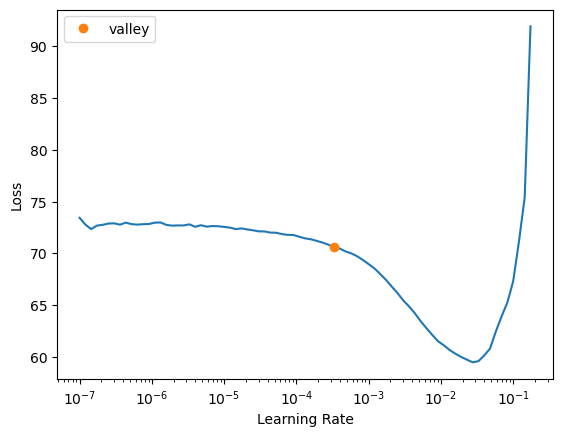

In [16]:
learner.lr_find()

In [20]:
# ssd_learner.freeze()
# ssd_learner.fit_one_cycle(3, 1e-3) # 没有lr_find之前的1e-3，参考来看

In [17]:
learner.freeze_to(5)
learner.fit_one_cycle(5, 0.00033)

In [18]:
learner.save('/home/zhr/SSD_jav_ssd_basic')

Path('/home/zhr/SSD_jav_ssd_basic.pth')

In [19]:
learner.load('/home/zhr/SSD_jav_ssd_basic', strict=True)

In [21]:
learner.freeze_to(5)
learner.lr_find()

SuggestedLRs(valley=9.120108734350652e-05)

In [22]:
learner.fit_one_cycle(10, slice(1e-5, 9.12e-5))

In [23]:
learner.save('/home/zhr/SSD_jav_ssd_freeze_5_1')

Path('/home/zhr/SSD_jav_ssd_freeze_5_1.pth')

In [24]:
learner.load('/home/zhr/SSD_jav_ssd_freeze_5_1', strict=True)

SuggestedLRs(valley=5.248074739938602e-05)

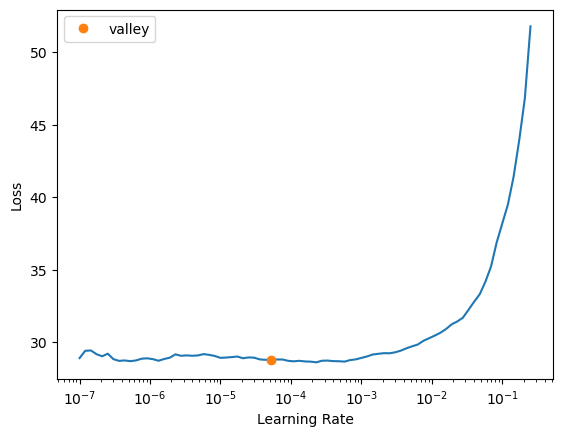

In [25]:
learner.freeze_to(5)
learner.lr_find()

In [26]:
learner.fit_one_cycle(10, slice(5e-6, 5.248074739938602e-5))

In [27]:
learner.save('/home/zhr/SSD_jav_ssd_freeze_5_2')

Path('/home/zhr/SSD_jav_ssd_freeze_5_2.pth')

In [28]:
learner.load('/home/zhr/SSD_jav_ssd_freeze_5_2', strict=True)

SuggestedLRs(valley=4.786300905834651e-06)

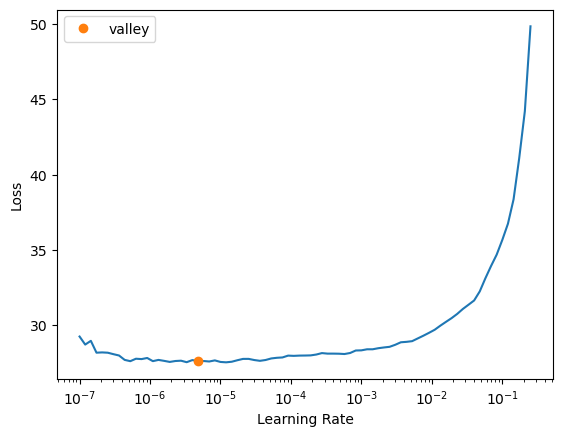

In [29]:
learner.freeze_to(5)
learner.lr_find()

In [30]:
learner.fit_one_cycle(13, slice(1e-6, 4.786e-6))

In [33]:
learner.save('/home/zhr/SSD_jav_ssd_freeze_5_3')

Path('/home/zhr/SSD_jav_ssd_freeze_5_3.pth')

In [10]:
learner.load('/home/zhr/SSD_jav_ssd_freeze_5_3', strict=True)

# unfreeze看结果

In [11]:
learner.unfreeze()

SuggestedLRs(valley=3.630780702224001e-05)

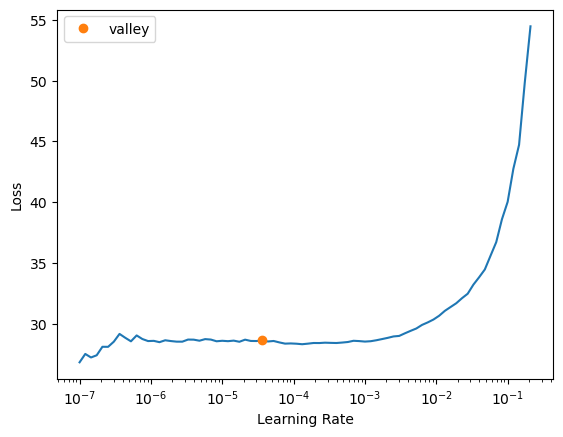

In [12]:
learner.lr_find()

In [13]:
learner.fit_one_cycle(13, slice(6e-7, 3.63e-5 ))

In [14]:
learner.save(F'/home/zhr/SSD_jav_ssd_unfreeze_4')

Path('/home/zhr/SSD_jav_ssd_unfreeze_4.pth')

In [15]:
learner.load(F'/home/zhr/SSD_jav_ssd_unfreeze_4', strict=True)

SuggestedLRs(valley=3.981071586167673e-06)

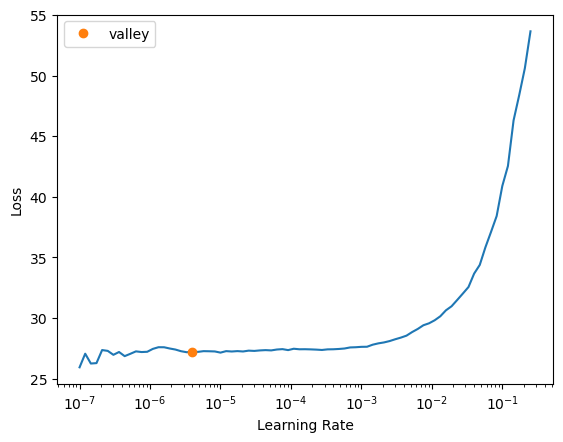

In [16]:
learner.lr_find()

In [17]:
learner.fit_one_cycle(13, slice(3.98e-6))

In [18]:
learner.save(F'/home/zhr/SSD_jav_ssd_unfreeze_5')

Path('/home/zhr/SSD_jav_ssd_unfreeze_5.pth')

In [19]:
learner.load(F'/home/zhr/SSD_jav_ssd_unfreeze_5', strict=True)

SuggestedLRs(valley=4.786300905834651e-06)

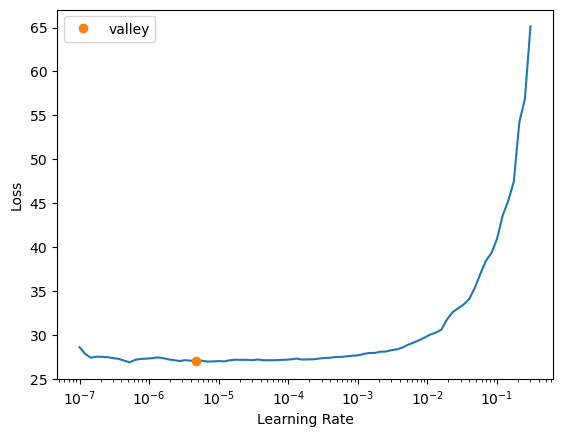

In [20]:
learner.unfreeze()
learner.lr_find()

In [21]:
learner.fit_one_cycle(13, slice(6e-7, 4.78e-6 ))

In [22]:
learner.save(F'/home/zhr/SSD_jav_ssd_unfreeze_6')

Path('/home/zhr/SSD_jav_ssd_unfreeze_6.pth')

In [23]:
learner.load(F'/home/zhr/SSD_jav_ssd_unfreeze_6', strict=True)

SuggestedLRs(valley=4.365158383734524e-05)

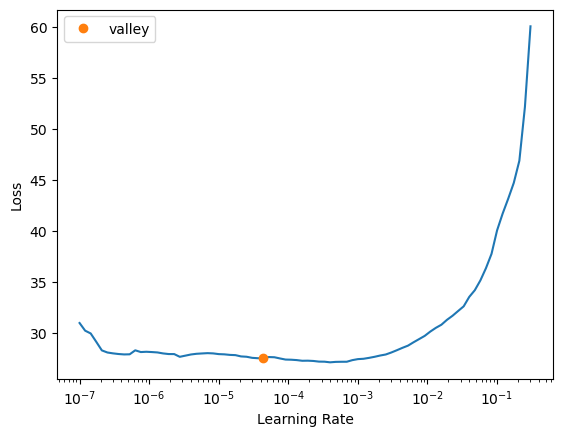

In [24]:
learner.unfreeze()
learner.lr_find()

In [25]:
learner.fit_one_cycle(13, slice(6e-7, 4.36e-5 ))

In [26]:
learner.save(F'/home/zhr/SSD_jav_ssd_unfreeze_7')

Path('/home/zhr/SSD_jav_ssd_unfreeze_7.pth')

In [10]:
learner.load(F'/home/zhr/SSD_jav_ssd_unfreeze_7', strict=True)

# 预测

In [19]:
del batch
del preds
del xb
del yb

In [20]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [10]:
batch = dls.valid.one_batch()
learner.model.to(device)
learner.model.eval()
preds = learner.model(batch[0])
xb = batch[0]
yb = batch[1:]

torch.Size([64, 3, 224, 224])


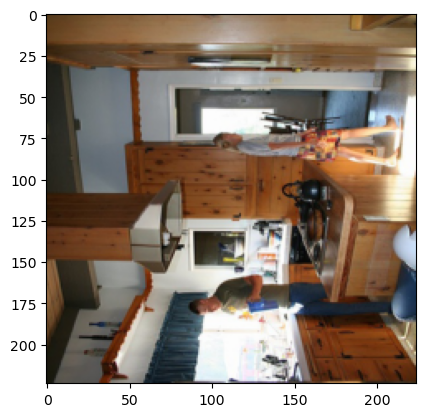

In [30]:
print(xb.shape)
plt.imshow(xb[0].permute(2,1,0).cpu())

In [15]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    # ax.set_xticks(np.linspace(0, 224, 8))
    # ax.set_yticks(np.linspace(0, 224, 8))
    # ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(dls.vocab) else dls.vocab[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox.cpu()*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

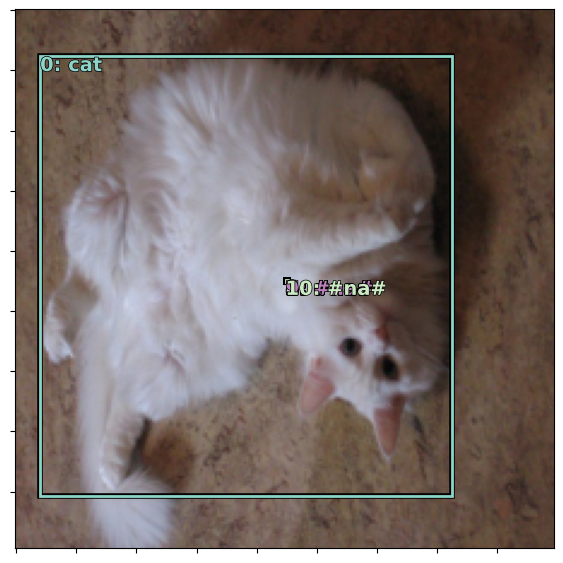

In [32]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
idx = 2
ima = xb[idx].permute(2,1,0).cpu()
torch_gt(ax, ima, yb[0][idx,:,:], yb[1][idx,:])

In [65]:
scores_z = torch.max(clas_pr)

In [17]:
idx=1
# print(yb[0][idx])
# print(yb[1][idx])
# print(bb_keep)
b,c = un_pad(torch.tensor(yb[0][idx]), torch.tensor(yb[1][idx]))
c

tensor([ 4, 15,  4], device='cuda:0')

In [59]:
t = [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# torch.masked_select(yb[1][idx], bb_keep)

In [20]:
my_bbox = torch.tensor([[1,2,3,4], [0,0,0,0]])
my_clas = torch.tensor([[1],[0]])

b,c = un_pad(my_bbox, my_clas)
c

tensor([[1]])

In [46]:
bb_keep = ((yb[0][idx][:,2] - yb[0][idx][:,0])>0)
t_bbox = yb[0][idx][bb_keep]
# t_clas = yb[1][idx][bb_keep]

In [69]:
b_bb, b_clas = preds
idx = 2
ima = xb[idx].permute(2,1,0).cpu()
nms_score_threshold = 0.25 # https://nbviewer.org/github/fastai/fastai1/blob/master/courses/dl2/pascal-multi.ipynb show_nmf
nms_iou_threshold = 0.5

# t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
bb_keep = ((yb[0][idx][:,2] - yb[0][idx][:,0])>0)
t_bbox = yb[0][idx][bb_keep]
# t_clas = yb[1][idx][bb_keep]

# bbox, clas = un_pad(b_bb[idx], b_clas[idx])|
a_ic = act_to_bbox(b_bb[idx], anchors)
clas_pr = b_clas[idx]
clas_pr = clas_pr.sigmoid()
scores_z = torch.max(clas_pr, dim=1, keepdim=True)[0] # 沿着行计算
scores_over_thresh = (scores_z > nms_score_threshold)[:, 0]
bbox = a_ic[scores_over_thresh]
classification_per = clas_pr[scores_over_thresh] # 取出分数
scores_, classes_ = classification_per.max(dim=1)

import torchvision.ops as ops
anchors_nms_idx = ops.batched_nms(bbox, 
                                scores_,
                                classes_, 
                                iou_threshold=nms_iou_threshold)
if anchors_nms_idx.shape[0] != 0:
    classes_ = classes_[anchors_nms_idx] # 0 is background and gets removed in metric, but is first class in model
    scores_ =scores_[anchors_nms_idx]
    boxes_ = bbox[anchors_nms_idx, :]
fig, ax = plt.subplots(1,2,figsize=(7,7))
torch_gt(ax.flat[0], ima, (t_bbox + 1)/2, yb[1][idx,:])
torch_gt(ax.flat[1], ima, (boxes_+1)/2, classes_, scores_)

In [74]:
def show_img_by_ndx(idx, nms_score_threshold=0.25):
    
    b_bb, b_clas = preds
    ima = xb[idx].permute(2,1,0).cpu()
    # nms_score_threshold = 0.25 # https://nbviewer.org/github/fastai/fastai1/blob/master/courses/dl2/pascal-multi.ipynb show_nmf
    nms_iou_threshold = 0.5

    # t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
    bb_keep = ((yb[0][idx][:,2] - yb[0][idx][:,0])>0)
    t_bbox = yb[0][idx][bb_keep]
    t_clas = yb[0][idx]
    # bbox, clas = un_pad(b_bb[idx], b_clas[idx])|
    a_ic = act_to_bbox(b_bb[idx], anchors) # 这里已经转换为角点了
    clas_pr = b_clas[idx]
    clas_pr = clas_pr.sigmoid()
    scores_z = torch.max(clas_pr, dim=1, keepdim=True)[0] # 沿着行计算
    scores_over_thresh = (scores_z > nms_score_threshold)[:, 0]
    bbox = a_ic[scores_over_thresh]
    classification_per = clas_pr[scores_over_thresh] # 取出分数
    scores_, classes_ = classification_per.max(dim=1)

    import torchvision.ops as ops
    anchors_nms_idx = ops.batched_nms(bbox, 
                                    scores_,
                                    classes_, 
                                    iou_threshold=nms_iou_threshold)
    if anchors_nms_idx.shape[0] != 0:
        classes_ = classes_[anchors_nms_idx] # 0 is background and gets removed in metric, but is first class in model
        scores_ =scores_[anchors_nms_idx]
        boxes_ = bbox[anchors_nms_idx, :] # 已经是角点了
    fig, ax = plt.subplots(1,2,figsize=(7,7))
    torch_gt(ax.flat[0], ima, (t_bbox + 1)/2, yb[1][idx,:])
    torch_gt(ax.flat[1], ima, (boxes_+1)/2, classes_, scores_)

In [20]:
(boxes_ + 1)/2*224

TensorImage([[ 48.3401,   4.9780, 176.0222, 224.6707]], device='cuda:0',
       grad_fn=<AliasBackward0>)

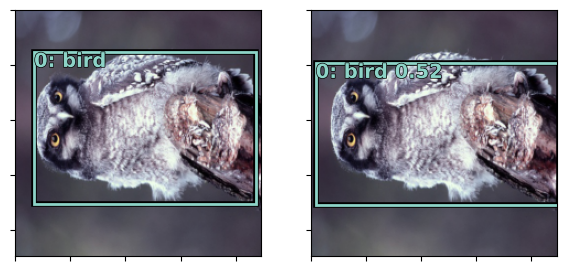

In [76]:
show_img_by_ndx(2, nms_score_threshold=0.005)

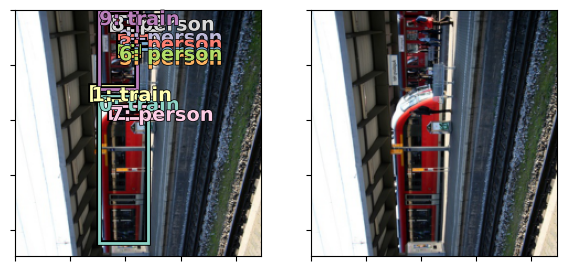

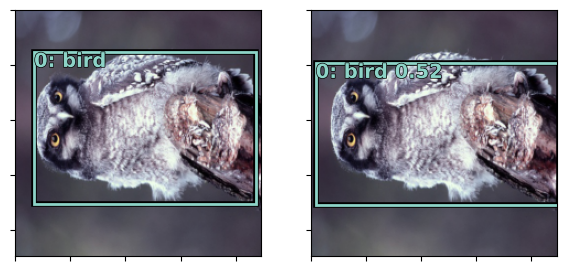

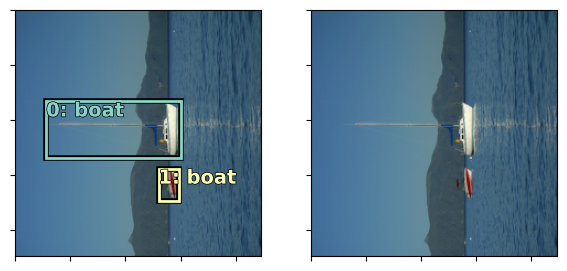

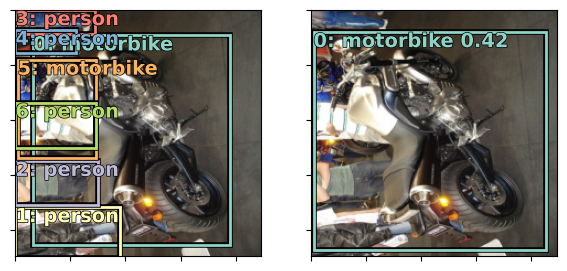

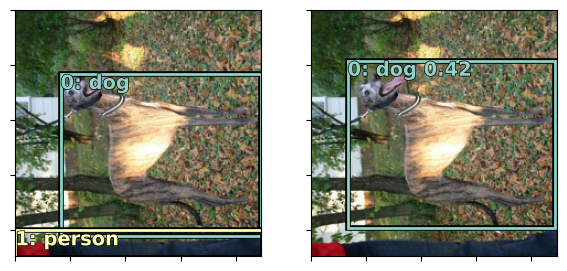

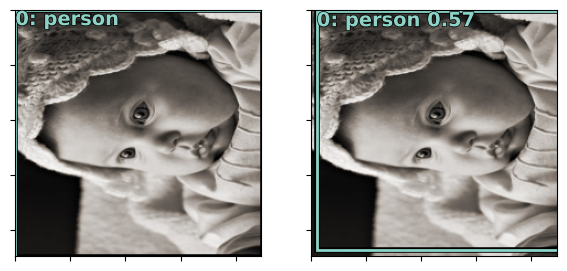

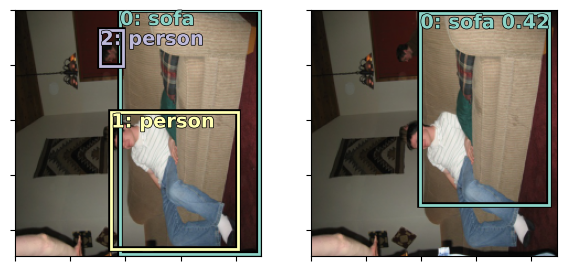

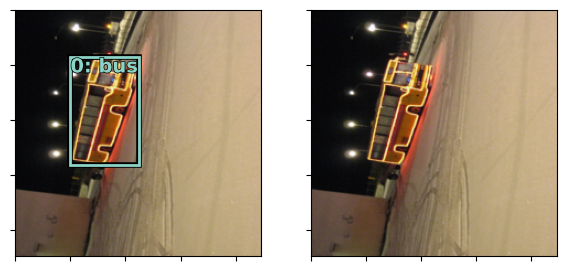

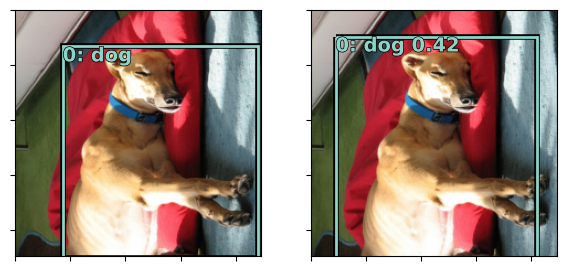

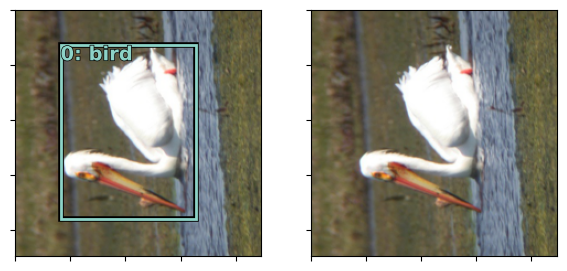

In [77]:
for i in range(1,16):
    show_img_by_ndx(i, nms_score_threshold=0.005)

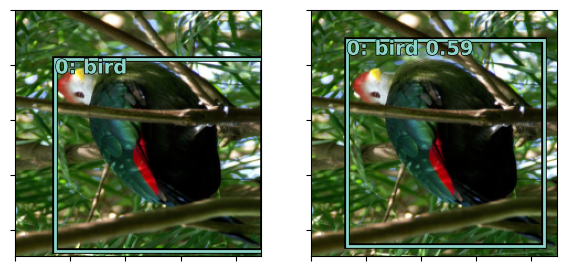

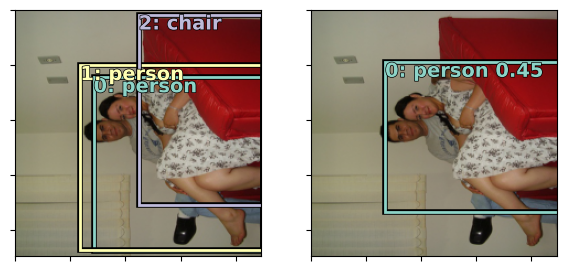

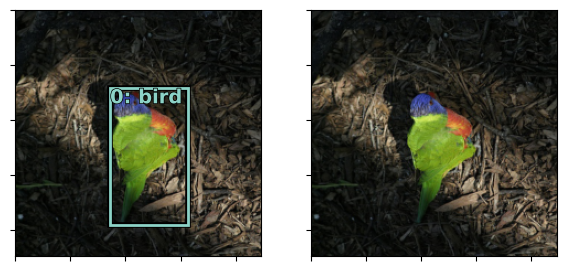

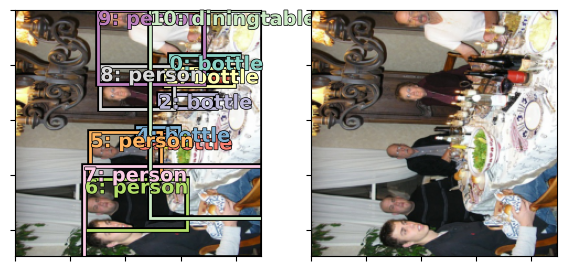

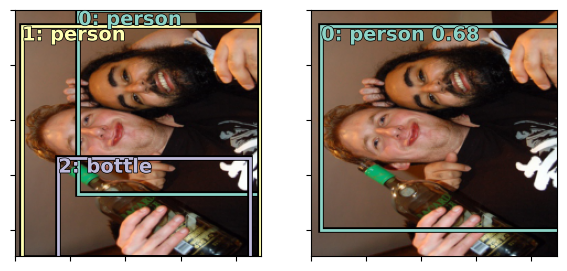

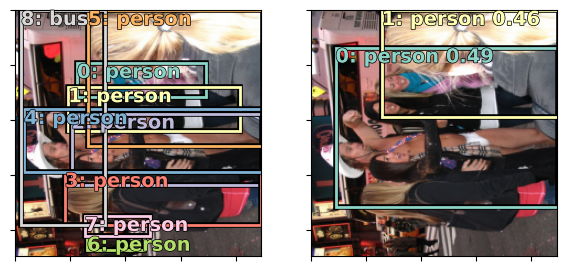

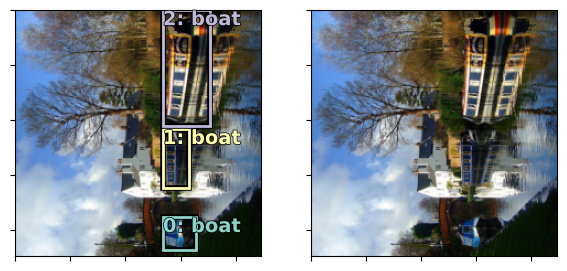

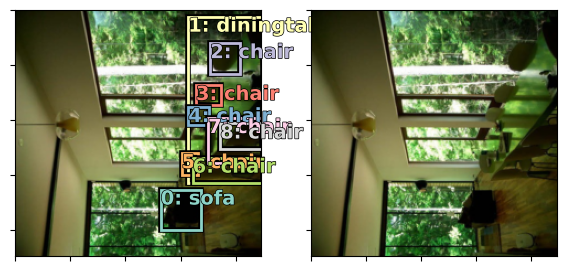

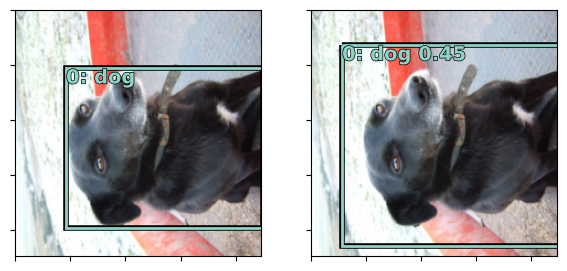

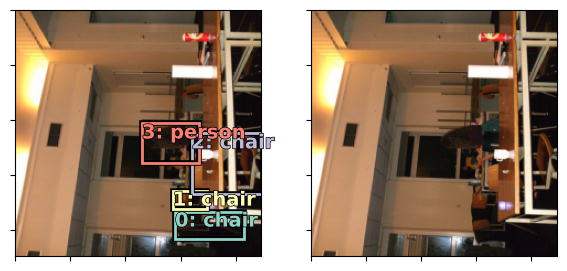

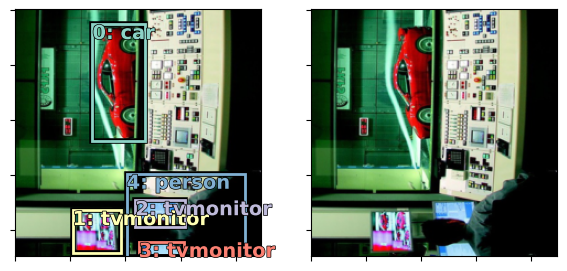

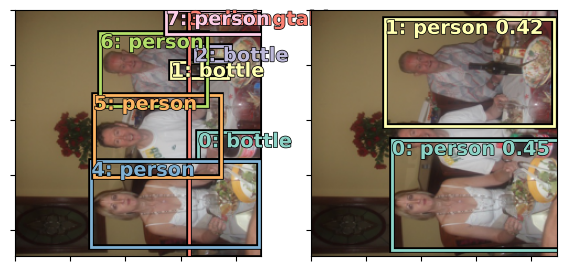

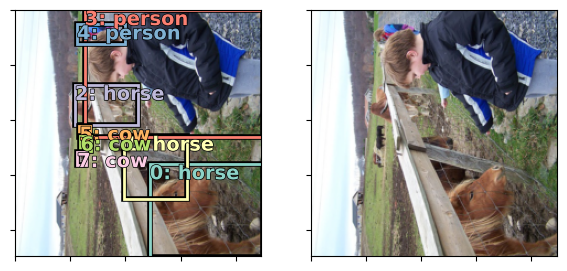

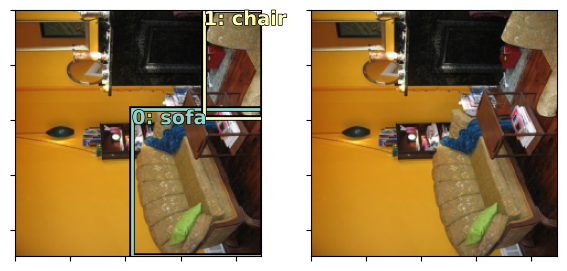

In [78]:
for i in range(17,33):
    show_img_by_ndx(i, nms_score_threshold=0.005)

In [81]:
fig, ax = plt.subplots(1,2,figsize=(7,7))

numpy.ndarray

In [77]:
print((scores_over_thresh == True).sum()) # 只剩下7个框了
print(boxes_.shape)

TensorImage(7, device='cuda:0')
torch.Size([1, 4])


In [41]:
print(a_ic.shape)
print(b_clas.shape)
print(clas_pr.shape)

torch.Size([189, 4])
torch.Size([64, 189, 21])
torch.Size([189])


In [55]:
# print((a_ic[:4] + 1)/2 * 224)
print(clas_pr.max().cpu())

TensorImage(0.5522, grad_fn=<AliasBackward0>)


In [59]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
torch_gt(ax, ima, (a_ic.cpu()+1)/2, clas_ids.cpu(), clas_pr.cpu(), clas_pr.max().cpu()*0.8)
# 没做nms，不好看，所以做个Nms

# mAP计算

In [10]:
learner.load(F'/home/zhr/SSD_jav_ssd_unfreeze_7', strict=True)

In [11]:
from ipywidgets import FloatProgress
from IPython.display import display

class mAP():
    def __init__(self, dls):
        self.dls = dls
        self.mAP = 0.0
        self.nms_iou_thresh = 0.5
        self.nms_score_threshold = 0.05

    def plot_prec_recall(self, clas, ax=None):
        tps = self.tps
        fps = self.fps
        fns = self.fns
        prec = np.where(tps[:,clas] + fps[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fps[:,clas]), 1)
        recal = np.where(tps[:,clas] + fns[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fns[:,clas]), 1)
        if ax is None:
            plt.plot(recal,prec)
        else:
            ax.plot(recal, prec)

    def avg_prec(self, clas):
        tps = self.tps
        fps = self.fps
        fns = self.fns
        precisions = np.where(tps[:,clas] + fps[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fps[:,clas]), 1)
        recalls = np.where(tps[:,clas] + fns[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fns[:,clas]), 1)
        prec_at_rec = []
        for recall_level in np.linspace(0.0, 1.0, 11):
            try:
                args = np.argwhere(recalls >= recall_level).flatten()
                prec = max(precisions[args])
            except ValueError:
                prec = 0.0
            prec_at_rec.append(prec)
        return np.array(prec_at_rec).mean()
    
    def calculate(self):
        learner.model.eval()
        self.tps, self.fps, self.fns = self.multiTPFPFN()#先计算各个类别的tp,fp,fn
        S = 0
        for i in range(len(self.dls.vocab)):
            S += self.avg_prec(i)
        self.mAP = S/len(self.dls.vocab)
        print(self.mAP)

    def get1preds(self, p_box, p_clas, gt_box, gt_clas):
        a_ic = act_to_bbox(p_box, anchors)
        clas_pr = p_clas.sigmoid()
        
        scores_z = torch.max(clas_pr, dim=1, keepdim=True)[0] # 沿着行计算
        scores_over_thresh = (scores_z > self.nms_score_threshold)[:, 0]
        bbox = a_ic[scores_over_thresh]
        classification_per = clas_pr[scores_over_thresh] # 取出分数
        scores_, classes_ = classification_per.max(dim=1)

        import torchvision.ops as ops
        anchors_nms_idx = ops.batched_nms(bbox, 
                                        scores_,
                                        classes_, 
                                        iou_threshold=self.nms_iou_thresh)
        if anchors_nms_idx.shape[0] != 0:
            classes_ = classes_[anchors_nms_idx] # 0 is background and gets removed in metric, but is first class in model
            scores_ =scores_[anchors_nms_idx]
            boxes_ = bbox[anchors_nms_idx, :] # 已经是角点了
        return scores_, boxes_, classes_

    def multiTPFPFN(self):
        def count(L):
            result = collections.defaultdict(int)
            if L is not None:
                for x in L:
                    result[x] += 1
            return result
        n = 40
        self.threshes = np.linspace(.05, 0.95, n, endpoint=True)
        tps,fps,fns = np.zeros((n,len(self.dls.vocab))),np.zeros((n,len(self.dls.vocab))),np.zeros((n,len(self.dls.vocab)))
        prog = FloatProgress(min=0,max=len(self.dls.valid))
        display(prog)

        for data in dls.valid:
            x, y = data[0], data[1:]
            learner.model.eval()
            preds = learner.model(x)#预测结果
            for idx in range(x.size(0)):# batch [bs,img]
                p_bbox, p_clas = preds
                gt_bbox,gt_clas = un_pad(y[0][idx],y[1][idx])
                p_scrs, p_box, p_cls = self.get1preds(p_bbox[idx], p_clas[idx], gt_bbox, gt_clas)

                overlaps = to_np(iou(p_box, gt_bbox))
                overlaps = np.where(overlaps > self.nms_iou_thresh, overlaps, 0)

                gt_clas, np_scrs, np_cls = to_np(gt_clas.data),to_np(p_scrs), to_np(p_cls)
                
                for k in range(self.threshes.shape[0]):
                    new_tp = collections.defaultdict(int)
                    for cls in list(set(gt_clas)):# 真实类别
                        msk_clas = np.bitwise_and((gt_clas == cls)[None,:],(np_cls == cls)[:,None])
                        ov_clas = np.where(msk_clas,overlaps,0.)
                        mx_idx = np.argmax(ov_clas,axis=1)
                        for i in range(0,len(gt_clas)):
                            if (gt_clas[i] == cls):
                                keep = np.bitwise_and(np.max(ov_clas,axis=1) > 0.,mx_idx==i)
                                keep = np.bitwise_and(keep,np_scrs > self.threshes[k])
                                if keep.sum() > 0:
                                    new_tp[cls] += 1
                    count_pred = count(np_cls[np_scrs > self.threshes[k]])
                    count_gt = count(gt_clas)
                    for c in range(len(self.dls.vocab)):
                        tps[k,c] += new_tp[c]
                        fps[k,c] += count_pred[c] - new_tp[c]
                        fns[k,c] += count_gt[c] - new_tp[c]
                prog.value += 1
            return tps, fps, fns

In [12]:
learner.model.to(device)
mAP_metric = mAP(dls)
mAP_metric.calculate()

FloatProgress(value=0.0, max=16.0)

0.3687118376154344


In [ ]:
    
b_bb, b_clas = preds
ima = xb[idx].permute(2,1,0).cpu()
# nms_score_threshold = 0.25 # https://nbviewer.org/github/fastai/fastai1/blob/master/courses/dl2/pascal-multi.ipynb show_nmf
nms_iou_threshold = 0.5

# t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
bb_keep = ((yb[0][idx][:,2] - yb[0][idx][:,0])>0)
t_bbox = yb[0][idx][bb_keep]
t_clas = yb[0][idx]
# bbox, clas = un_pad(b_bb[idx], b_clas[idx])|
a_ic = act_to_bbox(b_bb[idx], anchors) # 这里已经转换为角点了
clas_pr = b_clas[idx]
clas_pr = clas_pr.sigmoid()
scores_z = torch.max(clas_pr, dim=1, keepdim=True)[0] # 沿着行计算
scores_over_thresh = (scores_z > nms_score_threshold)[:, 0]
bbox = a_ic[scores_over_thresh]
classification_per = clas_pr[scores_over_thresh] # 取出分数
scores_, classes_ = classification_per.max(dim=1)

import torchvision.ops as ops
anchors_nms_idx = ops.batched_nms(bbox, 
                                scores_,
                                classes_, 
                                iou_threshold=nms_iou_threshold)
if anchors_nms_idx.shape[0] != 0:
    classes_ = classes_[anchors_nms_idx] # 0 is background and gets removed in metric, but is first class in model
    scores_ =scores_[anchors_nms_idx]
    boxes_ = bbox[anchors_nms_idx, :] # 已经是角点了
fig, ax = plt.subplots(1,2,figsize=(7,7))
torch_gt(ax.flat[0], ima, (t_bbox + 1)/2, yb[1][idx,:])
torch_gt(ax.flat[1], ima, (boxes_+1)/2, classes_, scores_)

In [83]:
print(len(dls.valid))
for data in dls.valid:
    print(data[0].shape)

16
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([42, 3, 224, 224])


In [ ]:
import numpy as np
# from fastai import *
# from fastai.callbacks import *
# md model这部分很难弄，所以直接放到代码中去

id2cats=learn.data.valid_dl.dl.dataset.y.classes

def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/size
    bb_keep = ((bbox[:,2] - bbox[:,0])>0.).nonzero()[:,0]
    return bbox[bb_keep], clas[bb_keep]
def get1preds(b_clas,b_bb,bbox,clas,thresh=0.25):
    bbox,clas = un_pad(bbox, clas)
    # import pdb
    # pdb.set_trace()
    a_ic = act_to_bbox(b_bb, anchors)# 预测框加上中心偏移 189*4
    clas_pr, clas_ids = b_clas.max(1)
    conf_scores = b_clas.sigmoid().t().data#21*189,第一个类别为0，忽略不计

    out1,out2,cc = [],[],[]
    for cl in range(conf_scores.size(0) - 1):#逐个类别计算
        cl = cl + 1
        cl_mask = conf_scores[cl] > thresh
        if cl_mask.sum() == 0: continue
        scores = conf_scores[cl][cl_mask]#取出这些预测的框的最大类别置信度
        l_mask = cl_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)#取出这些锚框，对应的预测框
        ids, count = nms(boxes.data, scores, 0.4, 50)#nms之后，再计算mAP的。
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = T(np.concatenate(cc)) if cc != [] else None
    out1 = torch.cat(out1) if out1 != [] else None
    out2 = torch.cat(out2) if out2 != [] else None
    return out1,out2,cc

def count(L):
    result = collections.defaultdict(int)
    if L is not None:
        for x in L:
            result[x] += 1
    return result

from ipywidgets import FloatProgress
from IPython.display import display

def multiTPFPFN(md:ImageDataBunch):
    n = 40
    threshes = np.linspace(.05, 0.95, n, endpoint=True)
    tps,fps,fns = np.zeros((n,len(id2cats))),np.zeros((n,len(id2cats))),np.zeros((n,len(id2cats)))
    prog = FloatProgress(min=0,max=len(md.valid_dl))
    display(prog)
    for data in md.train_dl:
        x,y = data
#         x,y = V(x),V(y)
        pred = learn.model(x)#预测结果
        for idx in range(x.size(0)):# batch [bs,img]
            bbox,clas = un_pad(y[0][idx],y[1][idx])#unpad the target
#             import pdb
#             pdb.set_trace()# pred[0]=bbox, pred[1]=clas, pred[0].shape=[189,4], pred[1].shape=[189,21]
            p_scrs,p_box,p_cls = get1preds(pred[1][idx],pred[0][idx],bbox,clas,threshes[0])
            # nms之后，保留下来的框
            overlaps = to_np(jaccard(p_box,bbox.data))
            overlaps = np.where(overlaps > 0.5, overlaps, 0)
#             import pdb
#             pdb.set_trace()
            clas, np_scrs, np_cls = to_np(clas.data),to_np(p_scrs), to_np(p_cls)
            for k in range(threshes.shape[0]):
                new_tp = collections.defaultdict(int)
                for cls in list(set(clas)):# 真实类别
                    msk_clas = np.bitwise_and((clas == cls)[None,:],(np_cls == cls)[:,None])
                    ov_clas = np.where(msk_clas,overlaps,0.)
                    mx_idx = np.argmax(ov_clas,axis=1)
                    for i in range(0,len(clas)):
                        if (clas[i] == cls):
                            keep = np.bitwise_and(np.max(ov_clas,axis=1) > 0.,mx_idx==i)
                            keep = np.bitwise_and(keep,np_scrs > threshes[k])
                            if keep.sum() > 0:
                                new_tp[cls] += 1
                count_pred = count(np_cls[np_scrs > threshes[k]])
                count_gt = count(clas)
                for c in range(len(id2cats)):
                    tps[k,c] += new_tp[c]
                    fps[k,c] += count_pred[c] - new_tp[c]
                    fns[k,c] += count_gt[c] - new_tp[c]
        prog.value += 1
    return tps, fps, fns

class mAP():
    def __init__(self, md:ImageDataBunch):
        self.md = md
        self.mAP = 0.0
    def plot_prec_recall(self, clas, ax=None):
        tps = self.tps
        fps = self.fps
        fns = self.fns
        prec = np.where(tps[:,clas] + fps[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fps[:,clas]), 1)
        recal = np.where(tps[:,clas] + fns[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fns[:,clas]), 1)
        if ax is None:
            plt.plot(recal,prec)
        else:
            ax.plot(recal, prec)

    def avg_prec(self, clas):
        tps = self.tps
        fps = self.fps
        fns = self.fns
        precisions = np.where(tps[:,clas] + fps[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fps[:,clas]), 1)
        recalls = np.where(tps[:,clas] + fns[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fns[:,clas]), 1)
        prec_at_rec = []
        for recall_level in np.linspace(0.0, 1.0, 11):
            try:
                args = np.argwhere(recalls >= recall_level).flatten()
                prec = max(precisions[args])
            except ValueError:
                prec = 0.0
            prec_at_rec.append(prec)
        return np.array(prec_at_rec).mean()
    def calculate(self):
        learn.model.eval()
        self.tps, self.fps, self.fns = multiTPFPFN(self.md)#先计算各个类别的tp,fp,fn
        S = 0
        for i in range(len(id2cats)):
            S += self.avg_prec(i)
        self.mAP = S/len(id2cats)
        print(self.mAP)

def intersection(box_a,box_b):
    min_xy = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    max_xy = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp(max_xy-min_xy,min=0)
    return inter[:,:,0] * inter[:,:,1]

def get_size(box):
    return (box[:,2]-box[:,0]) * (box[:,3] - box[:,1])

def jaccard(box_a,box_b):
    inter = intersection(box_a,box_b)
    union = get_size(box_a).unsqueeze(1) + get_size(box_b).unsqueeze(0) - inter
    return inter/union
def T(a, half=False, cuda=True):
    """
    Convert numpy array into a pytorch tensor. 
    if Cuda is available and USE_GPU=True, store resulting tensor in GPU.
    """
    if not torch.is_tensor(a):
        a = np.array(np.ascontiguousarray(a))
        if a.dtype in (np.int8, np.int16, np.int32, np.int64):
            a = torch.LongTensor(a.astype(np.int64))
        elif a.dtype in (np.float32, np.float64):
            a = to_half(a) if half else torch.FloatTensor(a)
        else: raise NotImplementedError(a.dtype)
    if cuda:
        a = to_gpu(a)
    return a
def to_gpu(x, *args, **kwargs):
    '''puts pytorch variable to gpu, if cuda is available and USE_GPU is set to true. '''
    return x.cuda(*args, **kwargs) if True else x

# 测试

In [33]:
def is_unfreeze(learner):
    '''
    Determines whether the next-to-last layer in the model is set to unfreeze or freeze
    '''
    c = 0
    for each in list(learner.model[0][-1][0].parameters()):
          if each.requires_grad: c += 1   
    if c == len(list(learner.model[0][-1][0].parameters())):
          return True 
    else:
          return False
  
def find_optimal_lr(learner, noise=5, show_df=None, show_min_values=False):
    '''
    Parameters 先执行lr_find，再从中自动找到最优的学习率
    
      learner:  The learner (mandatory)
      
      (Optional) 滤波参数
      noise:   Filtering parameter, set to 5. Suggest no to modify this value
      
      show_df: 'head' - Show the top 50 rows, 
               'tail' - Show the tail 50 rows
    
      show_min_values: True  - Display all values, min, and max 
                       False - Display min_loss and max_grad values
    
    Returns:
      optimun_lr - if freeze = True
      Suggested Best Slice - if freeze = False
      
    Author:  J. Adolfo Villalobos @ 2019  
    '''
    
    # Get loss values, corresponding gradients, and lr values from model.recorder 获取loss的最小，grad的最小值
    loss = np.array(learner.recorder.losses)
    loss_grad = np.gradient(loss)   
    # Transform lrs list to np array 将学习率转为numpy格式
    lrs = np.array(learner.recorder.lrs, dtype='float32')
    
    # Create a DataFrame with the data
    data = {'loss': loss.T, 'loss_grad': loss_grad.T, 'lrs': lrs.T}
    # 使用panda来计算足校和最大值
    df = pd.DataFrame(data, columns=['loss', 'loss_grad', 'lrs', 'min_loss', 'max_loss', 'min_grad', 'max_grad'])
      
    # Populate "min" and "max" columns for loss and gradient values filtering the noise with argrelextrema.     
    from scipy.signal import argrelextrema
    
    #********
    # IMPORTANT: n filters noise (sharp spikes in the data). Higher n value filters noise more aggressively. 
    # n = 5 seems to work best
    n=noise    
    #********
    
    df.min_loss = df.iloc[argrelextrema(df.loss.values, np.less_equal, order=n)[0]]['loss']
    df.max_loss = df.iloc[argrelextrema(df.loss.values, np.greater_equal, order=n)[0]]['loss']
    df.min_grad = df.iloc[argrelextrema(df.loss_grad.values, np.less_equal, order=n)[0]]['loss_grad']
    df.max_grad = df.iloc[argrelextrema(df.loss_grad.values, np.greater_equal, order=n)[0]]['loss_grad']

    # Optional: Display dataframe if show_df=True
    if show_df == 'head': print(df.head(50)) 
    elif show_df == 'tail': print(df.tail(50))     
        
    # Plot losses and loss gradients against lr values
    plt.figure(figsize=[8, 5])
    #figs, ax = plt.subplots(1,1)
    ax = plt.gca()
    color_loss = 'blue'
    color_grad = 'orange'
    color_green = 'green'
    color_red = 'red'

    ax.xaxis.grid(True) # x轴画上分割线
    ax.set_ylabel('Loss')
    ax.set_title('Learn Rate Finder')
    ax.tick_params(axis='y', labelcolor=color_loss)
    ax.semilogx(df.lrs, df.loss, c=color_loss )# loss随着lr变化的曲线
    
    # Define variable vertical size of the plot window, depending on the graph shape
    u_limit = max(df.loss.loc[(df.lrs < 0.1)].max(), 250)*2    
    ax.set_ylim([-200, u_limit])#y轴的数据有大小限制
   
    # Plot resulting line graphs
    ax2 = ax.twinx()
    ax2.set_ylabel('loss', color= color_grad)
    ax2.semilogx(df.lrs, df.loss_grad, c = color_grad)
    ax2.tick_params(axis='y', labelcolor = color_grad)
    
    # plot inflection points，红色是最小值
    ax.scatter(df.lrs, df.min_loss, c = color_red)    
    ax2.scatter(df.lrs, df.min_grad, c = color_red)    
    if show_min_values:# 绿色为最大值
        ax.scatter(df.lrs, df.max_loss, c = color_green)
        ax2.scatter(df.lrs, df.max_grad, c = color_green) 
    
    # Legends
    plt.LogFormatter(labelOnlyBase=False)
    ax.legend(labels=['loss','min_loss'], loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True, shadow=True)
    ax2.legend(labels=['loss_grad','min_grad'], loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=3, fancybox=True, shadow=True)
    plt.show()
    
    # Display resulting lr values, format varies depending of the state of the model's 
    # next-to-last layer ggroup: set to freeze or unfreeze    看模型的最后层是否是冻结状态
    if is_unfreeze(learner):
        # Yellow min_grad graph
        rev_tru_idx = df.min_grad.notna()[::-1]   
        optimun_lr_upper_bound_g = df.lrs.iloc[rev_tru_idx.idxmax()] 
        rev_tru_idx[rev_tru_idx.idxmax()] = False
        
#         pdb.set_trace()
        
        optimun_lr_lower_bound_1_g = df.lrs.iloc[rev_tru_idx.idxmax()]
        rev_tru_idx[rev_tru_idx.idxmax()] = False     
        optimun_lr_lower_bound_2_g = df.lrs.iloc[rev_tru_idx.idxmax()] 
      
        # Blue loss graph
        rev_tru_idx_loss = df.min_loss.notna()[::-1]   
        optimun_lr_upper_bound_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 
        rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = False    
        optimun_lr_lower_bound_1_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()]
        rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = False   
        optimun_lr_lower_bound_2_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 

        # Print results and return choices of lr slice
        print('Model set to: "unfreeze" or "freeze_to:"')      
        data = {'*Gradient - Orange Graph*' : [optimun_lr_upper_bound_g, optimun_lr_lower_bound_1_g, optimun_lr_lower_bound_2_g], 
              '*Loss - Blue Graph*' : [optimun_lr_upper_bound_l, optimun_lr_lower_bound_1_l, optimun_lr_lower_bound_2_l]}
        prdf = pd.DataFrame(data, index = ['First choice lr:', 'Second choice lr:', 'Third choice lr:' ])
        pd.options.display.float_format = '{:.10E}'.format
        #prdf.style.applymap('color: %s' % color_grad, subset=['*Gradient - Orange Graph*'])
        print(prdf)

        return optimun_lr_lower_bound_1_g, optimun_lr_upper_bound_g
      
    else:
        optimun_lr_upper_bound = df.lrs.iloc[df.min_grad.notna()[::-1].idxmax()]
        optimun_lr_lower_bound = df.lrs.iloc[df.min_loss.notna()[::-1].idxmax()]/10
        # Print results and return optimal lr
        print('Model set to "freeze":')
        print('  Optimun lr: {:.10E} '.format(optimun_lr_upper_bound))
        print('  Min loss divided by 10: {:.10E}'.format(optimun_lr_lower_bound))
        return optimun_lr_upper_bound 
     

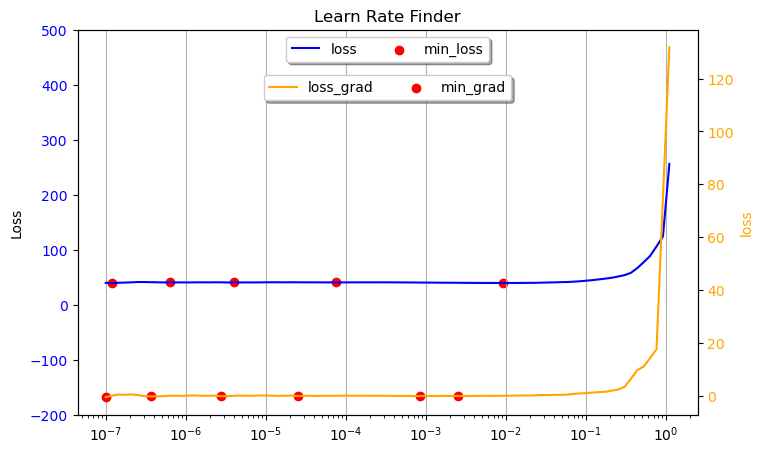

Model set to "freeze":
  Optimun lr: 2.5118864141E-03 
  Min loss divided by 10: 9.1201085597E-04


In [43]:
# Find Optimal Learning Rates
lr =  find_optimal_lr(ssd_learner)

In [44]:
ssd_learner.fit_one_cycle(10, 0.00120)

KeyboardInterrupt: 

In [120]:
body = learner.model.body
m = list(body)
list(m[0].parameters())

[Parameter containing:
 tensor([[[[ 5.4109e-03, -6.9092e-03,  7.8839e-03,  ...,  4.9072e-02,
             3.0660e-02,  2.5398e-02],
           [ 4.1081e-02,  3.1296e-02,  3.2265e-02,  ...,  3.3145e-02,
             2.9754e-02,  4.1735e-02],
           [ 4.9519e-03, -3.1705e-02, -6.1310e-02,  ..., -9.7493e-02,
            -1.1601e-01, -1.2191e-01],
           ...,
           [-1.2287e-02, -2.4841e-02, -9.3052e-03,  ...,  1.7113e-02,
             2.4631e-03,  1.6726e-02],
           [ 3.9117e-03,  4.4537e-03,  3.6315e-02,  ...,  1.0371e-01,
             7.3973e-02,  5.9085e-02],
           [ 1.6784e-02,  8.8902e-03,  3.1312e-02,  ...,  9.6964e-02,
             8.3749e-02,  9.6970e-02]],
 
          [[-7.7192e-03, -8.7711e-03,  1.4143e-02,  ...,  3.3901e-02,
             2.5483e-02,  2.4275e-02],
           [ 5.3961e-02,  4.4677e-02,  3.4326e-02,  ...,  1.3392e-02,
             1.9135e-02,  3.7995e-02],
           [ 1.0251e-03, -5.4513e-02, -1.0225e-01,  ..., -1.9231e-01,
            -1.9

In [132]:
# body[:2].parameters()
body[4:]

Sequential(
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [130]:
paramL = L(body[0:2], body[4],body[5]).map(params)

TypeError: list indices must be integers or slices, not Sequential

In [134]:
learner.opt.param_groups

[{'params': (#2) [Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): Batc

In [97]:
print(len(m)) # 共有8个list，然后后面4个都是序列块
for p in m:
    print(type(p))

8
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>


In [99]:
body_params = L()
for p in m:
    body_params += L(p).map(params)

TypeError: list indices must be integers or slices, not Conv2d

In [109]:
params(nn.Sequential(m))

TypeError: list is not a Module subclass

# 测试部分

In [44]:
"""测试解冻功能： 
    参考 https://github.com/fastai/fastai/blob/master/nbs/12_optimizer.ipynb
    分解为更简单的任务，增强技能后，再回来
"""
def tst_param(val, grad=None):
    res = tensor([val]).float()
    res.grad = tensor([val/10 if grad is None else grad]).float()
    return res

r = L.range(4)
def tst_params(): return r.map(tst_param)

params = [tst_params(), tst_params(), tst_params()]
opt = Optimizer(params, sgd_step, lr=0.1)
opt.freeze_to(1)

req_grad = Self.requires_grad()
test_eq(L(params[0]).map(req_grad), [False]*4)

for i in {1,2}: test_eq(L(params[i]).map(req_grad), [True]*4)

In [52]:
opt.freeze_to(-1)
opt.param_groups

[{'params': (#4) [tensor([0.]),tensor([1.]),tensor([2.]),tensor([3.])],
  'lr': 0.1},
 {'params': (#4) [tensor([0.]),tensor([1.]),tensor([2.]),tensor([3.])],
  'lr': 0.1},
 {'params': (#4) [tensor([0.], requires_grad=True),tensor([1.], requires_grad=True),tensor([2.], requires_grad=True),tensor([3.], requires_grad=True)],
  'lr': 0.1}]

In [53]:
opt.freeze_to(2)
opt.param_groups

[{'params': (#4) [tensor([0.]),tensor([1.]),tensor([2.]),tensor([3.])],
  'lr': 0.1},
 {'params': (#4) [tensor([0.]),tensor([1.]),tensor([2.]),tensor([3.])],
  'lr': 0.1},
 {'params': (#4) [tensor([0.], requires_grad=True),tensor([1.], requires_grad=True),tensor([2.], requires_grad=True),tensor([3.], requires_grad=True)],
  'lr': 0.1}]

In [49]:
print(r)
print(params)
type(params)
print(params[0][2].grad)
# test_eq(L(params[0]).map(req_grad), [False]*4)

opt.unfreeze()
for i in range(2): test_eq(L(params[i]).map(req_grad), [True]*4)
opt.param_groups

[0, 1, 2, 3]
[[tensor([0.], requires_grad=True), tensor([1.], requires_grad=True), tensor([2.], requires_grad=True), tensor([3.], requires_grad=True)], [tensor([0.], requires_grad=True), tensor([1.], requires_grad=True), tensor([2.], requires_grad=True), tensor([3.], requires_grad=True)], [tensor([0.], requires_grad=True), tensor([1.], requires_grad=True), tensor([2.], requires_grad=True), tensor([3.], requires_grad=True)]]
tensor([0.2000])


[{'params': (#4) [tensor([0.], requires_grad=True),tensor([1.], requires_grad=True),tensor([2.], requires_grad=True),tensor([3.], requires_grad=True)],
  'lr': 0.1},
 {'params': (#4) [tensor([0.], requires_grad=True),tensor([1.], requires_grad=True),tensor([2.], requires_grad=True),tensor([3.], requires_grad=True)],
  'lr': 0.1},
 {'params': (#4) [tensor([0.], requires_grad=True),tensor([1.], requires_grad=True),tensor([2.], requires_grad=True),tensor([3.], requires_grad=True)],
  'lr': 0.1}]

In [75]:
# 怎么对body的里面继续进行解冻，逐渐解冻到里面去？
params = [tst_params(), tst_params(), tst_params()]
opt = Optimizer(params, sgd_step, lr=0.1)

# 第2个列表的1和3号索引 保持训练模式，可以认为是BN
for p in L(params[1])[[1,3]]: opt.state[p] = {'force_train': True}
opt.freeze_to(2) 
# opt.freeze() # 冻结到-1层，默认的，最后一个list不冻结

# batchnorm权重/偏差等参数可以标记为始终处于训练模式，只需将force_train-true置于其状态即可。

In [76]:
opt.param_groups

[{'params': (#4) [tensor([0.]),tensor([1.]),tensor([2.]),tensor([3.])],
  'lr': 0.1},
 {'params': (#4) [tensor([0.]),tensor([1.], requires_grad=True),tensor([2.]),tensor([3.], requires_grad=True)],
  'lr': 0.1},
 {'params': (#4) [tensor([0.], requires_grad=True),tensor([1.], requires_grad=True),tensor([2.], requires_grad=True),tensor([3.], requires_grad=True)],
  'lr': 0.1}]

In [65]:
L(params[1])[[1,3]]

(#2) [tensor([1.]),tensor([3.])]

In [71]:
opt.state

defaultdict(dict,
            {tensor([1.], requires_grad=True): {'force_train': True},
             tensor([3.], requires_grad=True): {'force_train': True},
             tensor([0.], requires_grad=True): {},
             tensor([1.], requires_grad=True): {},
             tensor([2.], requires_grad=True): {},
             tensor([3.], requires_grad=True): {},
             tensor([0.]): {},
             tensor([1.]): {},
             tensor([2.]): {},
             tensor([3.]): {},
             tensor([0.]): {},
             tensor([2.]): {}})